In [2]:
import clip
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import os
from tqdm import tqdm

/Users/harrywang/sandbox/clip-tasks/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# select device: mps for Apple M1, cuda for GPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
#device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

mps


In [21]:
# local model and preprocessor
# see https://openai.com/blog/clip/ for info on different model
model, preprocess = clip.load("ViT-B/32", device=device)  # ViT-L/14@336px is the latest, ViT-B/32 is the first release, use ViT-L/14

In [22]:
# zero-shot classification for one image
labels = ['dawn', 'day', 'dusk', 'night']  # the target labels
text_prompts = ['An image taken at ' + label for label in labels]
print(text_prompts)

['An image taken at dawn', 'An image taken at day', 'An image taken at dusk', 'An image taken at night']


(-0.5, 766.5, 511.5, -0.5)

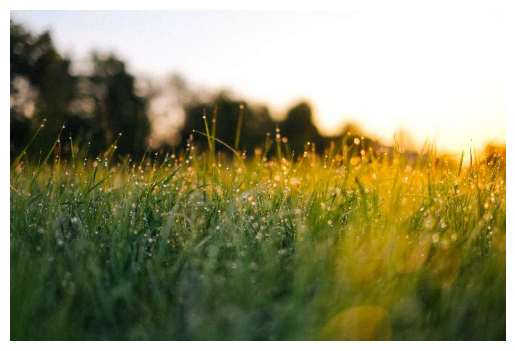

In [23]:
# try different images
#one_img = './1k-compressed/-bDYrrVAZnc.jpg'  # night
#one_img = './1k-compressed/-fjrjyS18BQ.jpg'  # dusk
im = './1k-compressed/-N_UwPdUs7E.jpg'  # dawn
#one_img = './1k-compressed/7kCNXfo35aU.jpg'  # day
#one_img = './1k-compressed/4_Bc9CSm70A.jpg'  # dusk or dawn
plt.imshow(Image.open(im))
plt.axis('off')

In [24]:
image = preprocess(Image.open(im)).unsqueeze(0).to(device)  # preprocess image
text = clip.tokenize(text_prompts).to(device)  # tokenize the text

with torch.no_grad():  # inference with no_grad
    image_features = model.encode_image(image)  # encode image
    text_features = model.encode_text(text)  # encode text
    
    logits_per_image, logits_per_text = model(image, text)
    
    #print(logits_per_image, logits_per_text)  # logits are the same
    
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # use softmax to get probabilities

print("Label probabilities:", probs)
choices = np.argmax(probs)  # use argmax to get the largest number as the prediction
print(f'This image is classified as taken at {labels[choices]}')

Label probabilities: [[0.4473  0.2319  0.3123  0.00872]]
This image is classified as taken at dawn


In [25]:
# classify 1k images
photos = pd.read_csv('photos-1k.csv')
photos.head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,XMyPniM9LF0,https://unsplash.com/photos/XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,2014-09-29 00:08:38.594364,t,4272,2848,1.50,Woman exploring a forest,michellespencer77,...,NaN,NaN,2375421,6967,woman walking in the middle of forest,NaN,NaN,NaN,NaN,L56bVcRRIWMh.gVunlS4SMbsRRxr
1,rDLBArZUl1c,https://unsplash.com/photos/rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,2014-11-18 19:36:57.08945,t,3000,4000,0.75,Succulents in a terrarium,ugmonk,...,NaN,NaN,13784815,82141,succulent plants in clear glass terrarium,NaN,NaN,NaN,NaN,LvI$4txu%2s:_4t6WUj]xat7RPoe
2,cNDGZ2sQ3Bo,https://unsplash.com/photos/cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,2015-01-01 20:02:02.097036,t,2564,1710,1.50,Rural winter mountainside,johnprice,...,NaN,NaN,1302461,3428,rocky mountain under gray sky at daytime,NaN,NaN,NaN,NaN,LhMj%NxvM{t7_4t7aeoM%2M{ozj[
3,iuZ_D1eoq9k,https://unsplash.com/photos/iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,2014-11-01 20:15:13.410073,t,2912,4368,0.67,Poppy seeds and flowers,krisatomic,...,NaN,NaN,2890238,33704,red common poppy flower selective focus phography,NaN,NaN,NaN,NaN,LSC7DirZAsX7}Br@GEWWmnoLWCnj
4,BeD3vjQ8SI0,https://unsplash.com/photos/BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,2014-11-26 13:13:50.134383,t,4896,3264,1.50,Silhouette near dark trees,jonaseriksson,...,NaN,NaN,8704860,49662,trees during night time,NaN,NaN,NaN,NaN,L25|_:V@0hxtI=W;odae0ht6=^NG


In [26]:
results = []

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    images = [
        preprocess(  # preprocess the images
            Image.open(f'./1k-compressed/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]  # process images in batch
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)  # encode images
        
        logits_per_image, logits_per_text = model(image_input, text)
        
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # softmax to get the probs from logits
        
        results.append(probs)

100%|██████████| 2/2 [00:47<00:00, 23.63s/it]


In [27]:
res = np.concatenate(results, axis=0)  # concat the result
choices = np.argmax(res, axis=1)  # choose the largest prob

get_labels = np.vectorize(lambda x:labels[x])  # vectorized lambda function to get labels
predictions = get_labels(choices)  # an array

print(len(predictions))  # total 1000 predictions
print(predictions[:10])  # see the first 10

# add the classification results to the dataframe
photos['taken_time'] = predictions

# save the dataframe to csv
photos.to_csv('photos-1k-pred.csv', index=False)

1000
['day' 'day' 'day' 'day' 'day' 'dawn' 'dawn' 'dawn' 'day' 'dawn']


In [9]:
# random verify the result
# sample one for each cls: dust, day, dawn, night

photos_pred = pd.read_csv('photos-1k-pred.csv')
samples = photos_pred.groupby('taken_time').sample(1)




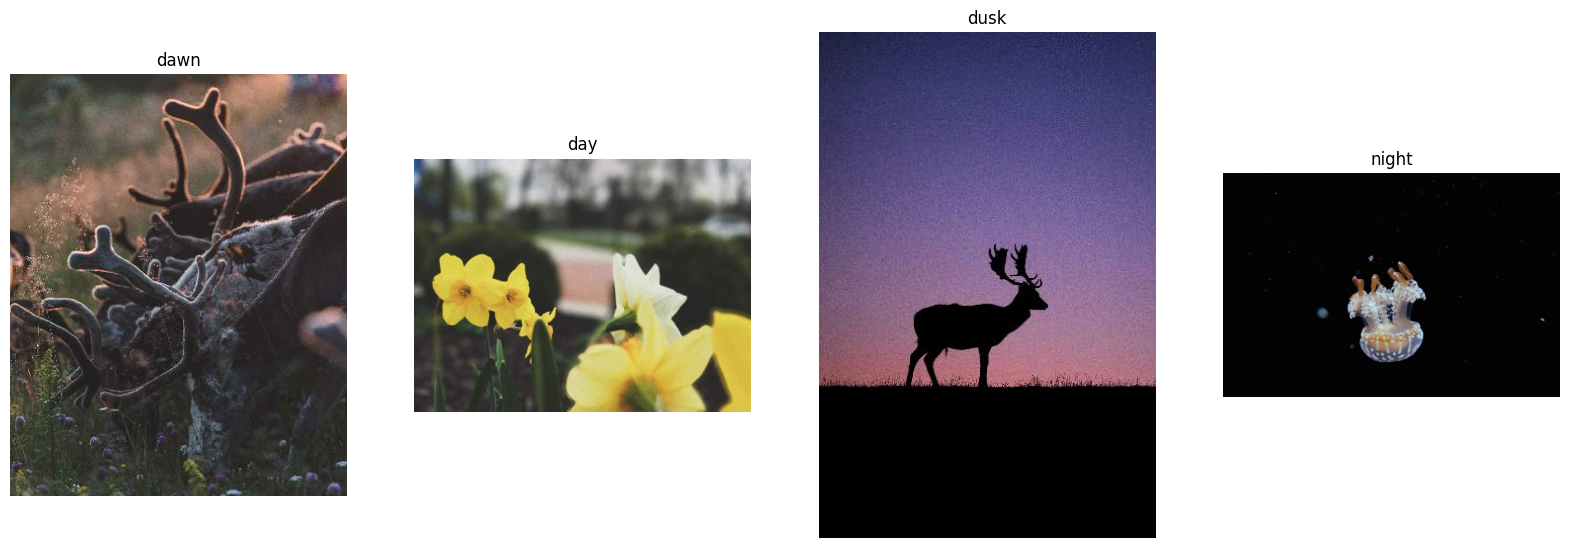

In [47]:
# random verify the result
# sample one for each cls: dust, day, dawn, night

photos_pred = pd.read_csv('photos-1k-pred.csv')
samples = photos_pred.groupby('taken_time').sample(1)

ids = list(samples.photo_id)
labels = list(samples.taken_time)
total_photos = len(ids)
top_photos = [f'./1k-compressed/'+ idx + '.jpg' for idx in ids]

# display the result horizontally 
fig = figure(figsize=(20, 80))

for i in range(total_photos):
    ax = fig.add_subplot(1, total_photos, i+1)
    image = imread(top_photos[i])
    imshow(image)
    ax.set_title(labels[i])
    axis('off')